<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9123_DL/blob/main/HW/HW4/hw4prob3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this problem we will use the BERT model for sentiment analysis. We will start with a pre-trained BERT model and fine-tune it on a dataset of Google Play store reviews.

## Setup

Install [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 2.8.0



## Data Exploration

Download the Google Play app reviews dataset using the following commands:

In [5]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 39.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 63.3MB/s]


Here is how it looks like:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Let's first check the size of the dataset. 

In [ ]:
# TODO: Q1. How many samples are there in this dataset? 
# There are 15746 samples in this dataset
df.shape

(15746, 11)

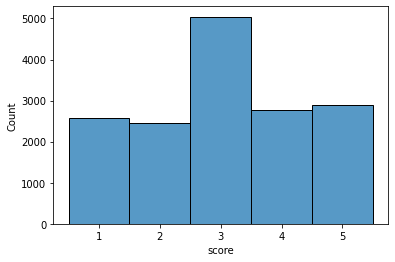

In [ ]:
# TODO: Q2. Plot a histogram of review scores. These can be accessed in the df.score field in the above dataframe. Which score is the most common?
# we can see that the score of 3 has the most.
sns.histplot(data=df['score'],discrete=True)

If correctly plotted, you should be able to see that this is a somewhat imbalanced dataset. Let's first convert the dataset into three classes: negative, neutral, and positive sentiment:

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
df['sentiment'].value_counts()

2    5676
1    5042
0    5028
Name: sentiment, dtype: int64

In [10]:
class_names = ['negative', 'neutral', 'positive']
vals = [5028,5042,5676]

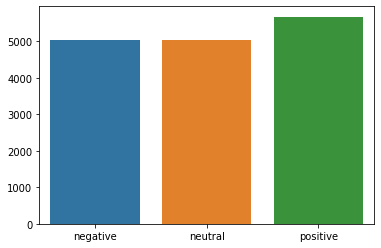

In [ ]:
# TODO: Q3. Plot the histogram of review sentiments, and show that it is now approximately balanced.
sns.barplot(x=class_names,y=vals)


## Data Preprocessing

Let's now load a pre-trained BERT model and the corresponding tokenizer, which converts text data into tokens. 


In [1]:
pip install transformers==2.8.0

     |████████████████████████████████| 573kB 5.2MB/s 
     |████████████████████████████████| 1.2MB 8.3MB/s 
     |████████████████████████████████| 890kB 25.6MB/s 
     |████████████████████████████████| 5.6MB 18.7MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 7.4MB 52.4MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=95b9b51740e4963723a94dcc6d860a4ec084851da9da2e0b74ba905cb0a2ceb2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for boto3: filename=boto3-1.17.43-py2.py3-none-any.whl size=128778 sha256=2ce07a6b623cc09902a2f937cfb30b1604d999f2b335634060674fcd33e9ba21
  Stored in directory: /root/.cache/pip/wheels/dc/b4/95/0327754601f89dfdae855ca2280bdaf249e625afd0ef17a4a3
Successfully built sacremoses boto3
ERROR: botocore 1.20.43 has requirement urlli

In [11]:
from transformers import BertModel, BertTokenizer

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's see how tokenization works. Here is the test sentence. Convert into tokens using the `tokenizer.tokenize` and `tokenizer.convert_tokens_to_ids` methods.



In [14]:
sample_txt = 'Every day feels like the same during the lock down.'

In [15]:
# TODO: Q4. Print the tokens and token ids of the sample text above.
print(tokenizer.tokenize(sample_txt))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample_txt)))


['Every', 'day', 'feels', 'like', 'the', 'same', 'during', 'the', 'lock', 'down', '.']
[4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205, 119]


BERT has special tokens for sentence separators \[SEP\] and unknown words \[UNK\]. This can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method, which takes the test sentence and encodes it into `input_ids`.

In [16]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [17]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205,  119,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [18]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Use the `tokenizer.convert_ids_to_tokens` method to invert the encoded token ids (the above tensor of length 32) and visualize the sentence.

In [19]:
# TODO: Q5. Invert the encoded token ids.
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Every',
 'day',
 'feels',
 'like',
 'the',
 'same',
 'during',
 'the',
 'lock',
 'down',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Most reviews in the dataset contain less than around 120 tokens, but let us choose a maximum length of 160.

In [20]:
MAX_LEN = 160

# Building the dataset

Let's now create a dataset using the tokenizer. Here is some code that does this:

In [21]:
 from torch.utils.data import Dataset

In [22]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data into 90-5-5 train-validation-test.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
len(df)

15746

In [25]:
# TODO: Q6. Create three data frames: df_train, df_val, df_test as above and print their shapes.
df_train, test_val = train_test_split(df, test_size=0.1, random_state = 42, shuffle=True)
df_val, df_test = train_test_split(test_val, test_size=0.5,random_state = 42, shuffle=True)

In [26]:
print(df_train.describe)
print(df_val.describe)
print(df_test.describe)

<bound method NDFrame.describe of                  userName  ... sentiment
1562               Raspiy  ...         0
15084        Ebony Sealey  ...         1
7417   Iindin the Edresia  ...         1
12044        Hydee Fisher  ...         1
12410       Tanya Ruppell  ...         0
...                   ...  ...       ...
5191            Mamatha t  ...         0
13418             chi mak  ...         0
5390      bhawna shraddha  ...         1
860       Adrian Anderson  ...         2
7270          Alec Machet  ...         0

[14171 rows x 12 columns]>
<bound method NDFrame.describe of                  userName  ... sentiment
1402                Chris  ...         0
850          Morhaf Osama  ...         2
11028        Girish Palve  ...         0
1655         Mauri Galvez  ...         1
14287  Jennifer V Mendoza  ...         2
...                   ...  ...       ...
7234        sventhedog gy  ...         0
15641    Arvind Ramshetty  ...         2
101          Joe Joejambo  ...         0
23

We also need to create a couple of data loaders:

In [27]:
from torch.utils.data import DataLoader

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [29]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's have a look at an example batch from our training data loader:

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


Let's now load the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Load the model using:

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And encode our sample text:

In [40]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)


The `last_hidden_state` is the sequence of hidden states of the last layer of the model. The `pooled_output` can be thought of as a summary of the content in the test sentence. Try printing out the sizes of `last_hidden_state` and `pooled_output`:

In [46]:
# TODO: Q7. Print the sizes of the hidden states and the pooled output.
print(last_hidden_state.size())

print(pooled_output.size())

torch.Size([1, 32, 768])
torch.Size([1, 768])


We can use all of this knowledge to create a classifier that uses the BERT model:

In [47]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
    )
    output = self.drop(pooled_output)
    return self.out(output)

Note that our sentiment classifier takes the BERT backbone and adds a dropout layer (for regularization) and a linear dense layer, which we train using cross-entropy. Let's create an instance and move it to the GPU:

In [48]:
model = SentimentClassifier(len(class_names))
device = torch.device('cuda:0')
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [49]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [50]:
outputs1 = model(
  input_ids=input_ids,
  attention_mask=attention_mask
)
prob = F.softmax(outputs1, dim=1)

In [52]:
print(outputs1)

tensor([[ 0.8036, -0.0667,  0.2384],
        [ 0.5499,  0.4858, -0.0507],
        [ 0.4662,  0.3497, -0.1027],
        [ 0.5791,  0.2475, -0.1871],
        [ 0.8534,  0.2436,  0.4002],
        [ 0.5620,  0.3253,  0.2839],
        [ 0.3429, -0.1134,  0.3472],
        [ 0.6116,  0.1117, -0.1785],
        [ 0.7330,  0.2370,  0.2766],
        [ 0.8563,  0.2086,  0.3081],
        [ 0.4379,  0.2441,  0.1245],
        [ 0.7415,  0.1494, -0.3459],
        [ 0.4121,  0.0639, -0.0375],
        [ 0.6646,  0.5053,  0.2297],
        [ 0.3990, -0.1190, -0.0300],
        [ 0.3602,  0.2597, -0.1292]], device='cuda:0', grad_fn=<AddmmBackward>)


### Training

To train the model, we will use the AdamW optimizer and a linear learning-rate scheduler with no warmup steps, along with the cross-entropy loss. Five epochs (full passes through the training data should be enough) should be enough, but you can experiment with more epochs.

In [53]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [54]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [61]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    # TODO Q8. Complete the incomplete code snippets below to finish training.
    
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += 1
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Let's write another function that helps us evaluate the model on a given data loader.

In [62]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  # TODO: Q9. Reproduce the above code but only evaluate the model (without any weight updates).
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += 1
    losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop.

In [59]:
from collections import defaultdict

In [63]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # TODO: Q10. Complete the code below to track train and test accuracy.losses

  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train_data_loader))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(val_data_loader))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


AttributeError: ignored

Note that we're storing the best model, indicated by the highest validation accuracy.

Plot train and validation accuracy as a function of epoch count.

In [ ]:
# TODO: Q11. Plot train/validation accuracies.
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

You might try to fine-tune the parameters (learning rate, batch size) a bit more if accuracy is not good enough.


## Evaluation

So how good is our model on predicting sentiment?

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let us compare true sentiment vs predicted sentiment by plotting a confusion matrix of `y_test` vs `y_pred`.

In [ ]:
# TODO. Q12. Plot the 3x3 confusion matrix and show that the model finds it a bit difficult to classify neutral reviews.


### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love Deep Learning! Best course evah!!!1!!"

Use your trained model to predict the sentiment expressed in `review_text`.


In [ ]:
# TODO: Q13. Print the predicted sentiment in `review_text`.



## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)